# MNIST Project

Answer Slack: Do not test too many architectures. For this task I would advise towards focusing on *how to treat the input* (single two channel image, two single channel images which is better and why? What if we use FC instead of conv?) and *how to make use of the extra labels* (auxiliary losses).

## Imports

In [101]:
import torch
from torch import Tensor 
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
import src.dlc_practical_prologue as prologue
import matplotlib.pyplot as plt

import sys
if sys.version_info[0] == 3:
    from importlib import reload

## Loading the Data

In [104]:
reload(prologue)
N = 1000
# Trainingset: train_X (train_input) & train_Y (train_target)
# Testset: test_X (test_input) & test_Y (test_target)
train_X, train_Y, train_Class, test_X, test_Y, test_Class = prologue.generate_pair_sets(N)

In [105]:
%%capture
mu, std = train_X.mean(), train_X.std()
train_X.sub_(mu).div_(std)
test_X.sub_(mu).div_(std)

# Functions for Training and Testing

In [22]:
def train_model(model, criterion, optimizer, nb_epochs, minibatch_size, train_X, train_Y, verbose=False):
    for e in range(nb_epochs):
        for b in range(0, train_X.size(0), minibatch_size):
            out = model(train_X.narrow(0, b, minibatch_size))
            loss = criterion(out, train_Y.narrow(0, b, minibatch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
        if(verbose): print(compute_nb_errors(model, train_X, train_Y, minibatch_size))
    return model

In [121]:
def train_model_path(model, criterion, optimizer, nb_epochs, minibatch_size, train_X, train_Y, test_X, test_Y, verbose=False):
    train_error = []
    test_error = []
    for e in range(nb_epochs):
        for b in range(0, train_X.size(0), minibatch_size):
            out = model(train_X.narrow(0, b, minibatch_size))
            loss = criterion(out, train_Y.narrow(0, b, minibatch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
        train_error.append(compute_nb_errors(model, train_X, train_Y, minibatch_size))
        test_error.append(compute_nb_errors(model, test_X, test_Y, minibatch_size))
        if(verbose): print(compute_nb_errors(model, train_X, train_Y, minibatch_size))
    return model, train_error, test_error

In [161]:
def train_model_aux(model, model_aux, criterion, optimizer, nb_epochs, minibatch_size, train_X, train_Y, \
                     test_X, test_Y, train_X_14px, train_Class_14px, beta=1, verbose=False):
    train_error = []
    test_error = []
    for e in range(nb_epochs):
        for b in range(0, train_X.size(0), minibatch_size):
            # primary loss given by ConvNet
            out = model(train_X.narrow(0, b, minibatch_size))
            loss = criterion(out, train_Y.narrow(0, b, minibatch_size))
            # auxiliary loss given by digit predictor net
            out_aux = model_aux(train_X_14px.narrow(0, b, minibatch_size))
            loss_aux = criterion(out_aux, train_Class_14px.narrow(0, b, minibatch_size))
            total_loss = loss + beta*loss_aux
            model.zero_grad()
            total_loss.backward()
            optimizer.step()
        train_error.append(compute_nb_errors(model, train_X, train_Y, minibatch_size))
        test_error.append(compute_nb_errors(model, test_X, test_Y, minibatch_size))
        if(verbose): print(compute_nb_errors(model, train_X, train_Y, minibatch_size))
    return model, train_error, test_error

In [149]:
def compute_nb_errors(model, data_input, data_target, minibatch_size):
    nb_data_errors = 0
    for b in range(0, data_input.size(0), minibatch_size):
        out = model(data_input.narrow(0, b, minibatch_size))
        # compares the outputted values for the two channels and gives back the argmax (in pred)
        _, pred = torch.max(out.data, 1)
        for k in range(minibatch_size):
            if data_target[b+k] != pred[k]:
                nb_data_errors += 1
    return nb_data_errors

## Model 0: Multi-Layer Perceptron
- To give a baseline performance
- using two hidden layers

In [129]:
# flatten the input data as we use a fully-connected neural network.
train_X = train_X.view(train_X.size(0), -1)
test_X = test_X.view(test_X.size(0), -1)

In [123]:
class MLP(nn.Module):
    """Neural Network definition, Multi Layer Perceptron"""
    def __init__(self):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(392, 784)  
        self.l2 = nn.Linear(784, 200)  
        self.l3 = nn.Linear(200, 2)    
 
    def forward(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

In [126]:
model0 = MLP()
model0, train_path, test_path = train_model_path(model0, nn.CrossEntropyLoss(), optim.SGD(model0.parameters(), lr=1e-1), \
                                                 50, 100, train_X, train_Y, test_X, test_Y, verbose=False)

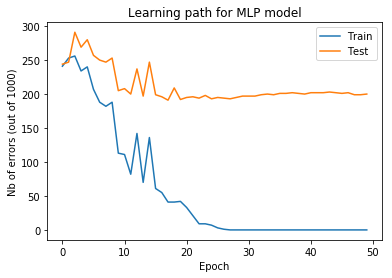

Final Test Error: 200/1000


In [130]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for MLP model')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(model0, test_X, test_Y, 100)))

It is obvious that a simple MLP with two hidden layers completely overfits to the trainingset while explaining the testset insufficiently. A more sophisticated model has hence to be developed.

## Model 1: Naive convnet
For the first model, we create a naive convnet, not taking into account the structure of the channels. I.e. we directly focus on predicting for each pair if the first digit is lesser or equal to the second without using information about the 9 possible classes of digits

In [143]:
# make sure the input images are again in their natural form (after flattening for the MLP)
train_X = train_X.view(N,2,14,14)
test_X = test_X.view(N,2,14,14)

In [21]:
class convNet(nn.Module):
    def __init__(self):
        super(convNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [25]:
model1 = convNet()
model1, train_path, test_path = train_model_path(model1, nn.CrossEntropyLoss(), optim.SGD(model1.parameters(), lr=1e-1), \
                                                 100, 100, train_X, train_Y, test_X, test_Y, verbose=False)

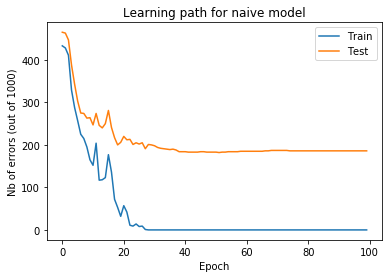

Final Test Error: 186/1000


In [26]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for naive model')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(model1, test_X, test_Y, 100)))

We observe that this model does not manage to learn the mapping very well.

## Model 2: Using transfer learning

Idea: The task of predicting the digit for MNIST images is well-known and powerful frameworks exist already. Inspiring us from these approaches, we can build a network that also works well on predicting the digit for 14x14 images. Once we know the two digits of each pair, it is an easy task to predict which digit is smaller or equal.

### Part 1: Study of a good functioning digit detection network for 28x28 images

In [136]:
# load normal MNIST dataset
train_input, train_target, test_input, test_target = \
    prologue.load_data(one_hot_labels = False, normalize = True, flatten = False)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [28]:
train_input, train_target = Variable(train_input), Variable(train_target)
model = Net()

In [29]:
model = train_model(model, nn.CrossEntropyLoss(), optim.SGD(model.parameters(), lr=1e-1), 50, 100, train_input, train_target)

In [30]:
print('Final Test Error: {}/1000'.format(compute_nb_errors(model, test_input, test_target, 100)))

Final Test Error: 64/1000


We see that a LeNet5-like network does a decent job in predicting digits from MNIST images of size 28x28.

### Part 2: Adapting the network to 14x14 images

**Goal:** Make the digit-predictor network also function for 14x14 images. 

In [31]:
# fist, create the training and testing dataset
train_target_14px = torch.cat((train_Class[:,0], train_Class[:,1]))
train_input_14px = torch.cat((train_X[:,0,:,:].view(1000,1,14,14), train_X[:,1,:,:].view(1000,1,14,14)))

test_target_14px = torch.cat((test_Class[:,0], test_Class[:,1]))
test_input_14px = torch.cat((test_X[:,0,:,:].view(1000,1,14,14), test_X[:,1,:,:].view(1000,1,14,14)))

train_input_14px, train_target_14px = Variable(train_input_14px), Variable(train_target_14px)

In [32]:
class Net_14px(nn.Module):
    def __init__(self):
        super(Net_14px, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2)) #image size 12x12-> image size 6x6
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2)) #image size 4x4 -> image size 2x2
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [33]:
model_14px = Net_14px()
model_14px, train_path, test_path = train_model_path(model_14px, nn.CrossEntropyLoss(), optim.SGD(model_14px.parameters(), lr=1e-1), 50, 100, \
                         train_input_14px, train_target_14px, test_input_14px, test_target_14px, verbose=False)

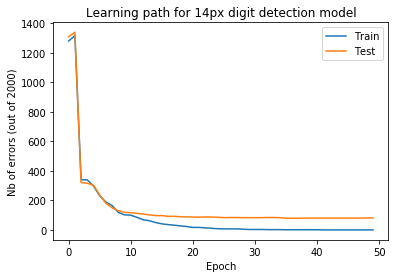

Final Test Error: 81/2000


In [34]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for 14px digit detection model')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 2000)')
plt.legend()
plt.show()
print('Final Test Error: {}/2000'.format(compute_nb_errors(model_14px, test_input_14px, test_target_14px, 100)))


Surprisingly, the test error is even a bit lower than what had been observed for the 28x28 images.

### Part 3: Siamese Net with Parameter Sharing

In [154]:
class siamese_Net(nn.Module):
    def __init__(self):
        super(siamese_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 100)
        self.fc3 = nn.Linear(200, 10) # input dim is 200 as we concatenate x1 and x2 (2*100)
        self.fc4 = nn.Linear(10,2)

    def forward(self, x):
        ### First images of each pair ###
        #image size 12x12-> image size 6x6
        x1 = F.relu(F.max_pool2d(self.conv1(x[:,0,:,:].view(x.size(0),1,14,14)), kernel_size=2, stride=2)) 
        #image size 4x4 -> image size 2x2
        x1 = F.relu(F.max_pool2d(self.conv2(x1), kernel_size=2, stride=2)) 
        x1 = F.relu(self.fc1(x1.view(-1, 256)))
        
        ### Second images of each pair ###
        #image size 12x12-> image size 6x6
        x2 = F.relu(F.max_pool2d(self.conv1(x[:,1,:,:].view(x.size(0),1,14,14)), kernel_size=2, stride=2)) 
        #image size 4x4 -> image size 2x2
        x2 = F.relu(F.max_pool2d(self.conv2(x2), kernel_size=2, stride=2)) 
        x2 = F.relu(self.fc1(x2.view(-1, 256)))
        
        # concatenate the features x1 and x2 of the two images again and let them pass through 2 fully connected layers
        x = F.relu(self.fc3(torch.cat((x1.view(-1,100), x2.view(-1, 100)), 1)))
        x = self.fc4(x)
        return x

In [145]:
sNet = siamese_Net()

In [151]:
# to warm-start the model: use the learned parameters of the 14px model as initialization

# save the previously learned 14px digit-predictor model (from part 2)
torch.save(model_14px.state_dict(), 'networks/model_14px.pt')
# Copy parameters and buffers from 14px model into sNet
sNet.load_state_dict(torch.load('networks/model_14px.pt'), strict=False)

In [150]:
sNet, train_path, test_path = train_model_path(sNet, nn.CrossEntropyLoss(), optim.SGD(sNet.parameters(), lr=1e-1), \
                                                 50, 100, train_X, train_Y, test_X, test_Y, verbose=False)

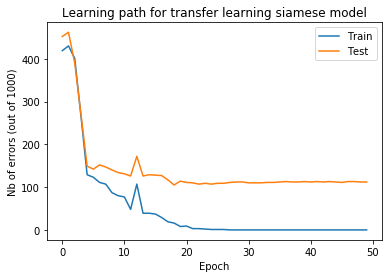

Final Test Error: 112/1000


In [40]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for transfer learning siamese model')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(sNet, test_X, test_Y, 100)))

The best test error achieved so far.

# Model 3: Siamese Net without Pretraining

In [41]:
sNet2 = siamese_Net()

In [42]:
sNet2, train_path, test_path = train_model_path(sNet2, nn.CrossEntropyLoss(), optim.SGD(sNet2.parameters(), lr=1e-1), \
                                                 50, 100, train_X, train_Y, test_X, test_Y, verbose=False)

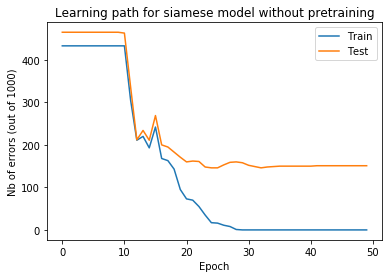

Final Test Error: 151/1000


In [43]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for siamese model without pretraining')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(sNet2, test_X, test_Y, 100)))

The test error is considerably higher than with pre-training. Hence, it makes sense to do warm-starting.

## Model 4: Siamese Net with Pretraining, not updating the convolution layer parameters:
Therefore keeping the feature extractor

In [44]:
sNet3 = siamese_Net()

In [45]:
sNet3.load_state_dict(torch.load('networks/model_14px.pt'), strict=False)

In [46]:
for p in sNet3.conv1.parameters():
    p.requires_grad = False
for p in sNet3.conv2.parameters():
    p.requires_grad = False

In [47]:
sNet3, train_path, test_path = train_model_path(sNet3, nn.CrossEntropyLoss(), optim.SGD(sNet3.parameters(), lr=1e-1), \
                                                 50, 100, train_X, train_Y, test_X, test_Y, verbose=False)

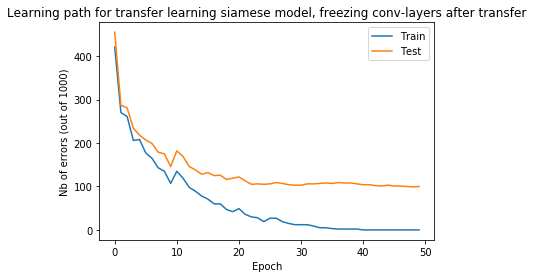

Final Test Error: 100/1000


In [48]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for transfer learning siamese model, freezing conv-layers after transfer')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(sNet3, test_X, test_Y, 100)))

The achieved test error is roughly in the same range as the one achieved with pretraining and updating the convolutional layers.

## Model 5: ConvNet with Auxiliary Loss

In [162]:
# fist, create the training and testing dataset
train_target_14px = torch.cat((train_Class[:,0], train_Class[:,1]))
train_input_14px = torch.cat((train_X[:,0,:,:].view(1000,1,14,14), train_X[:,1,:,:].view(1000,1,14,14)))

test_target_14px = torch.cat((test_Class[:,0], test_Class[:,1]))
test_input_14px = torch.cat((test_X[:,0,:,:].view(1000,1,14,14), test_X[:,1,:,:].view(1000,1,14,14)))

train_input_14px, train_target_14px = Variable(train_input_14px), Variable(train_target_14px)

In [165]:
model5 = convNet()
model5_aux = Net_14px()
model5, train_path, test_path = train_model_aux(model5, model5_aux, nn.CrossEntropyLoss(), \
                                                optim.SGD(model5.parameters(), lr=1e-1), 50, 100, \
                                                train_X, train_Y, test_X, test_Y, \
                                                train_input_14px, train_target_14px, beta=1, verbose=False)

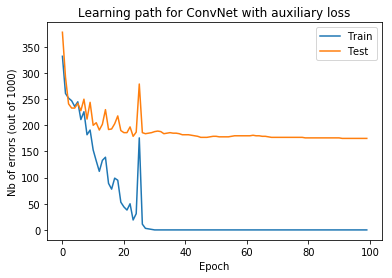

Final Test Error: 175/1000


In [167]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for ConvNet with auxiliary loss')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(model5, test_X, test_Y, 100)))

### Optimize hyperparameter beta (weighting factor between the general and auxiliary loss)

In [185]:
models = []
train_paths = []
test_paths = []

for i in range(0,21):
    print("Training with new beta = ", i/10)
    model5 = convNet()
    model5_aux = Net_14px()
    model5, train_path, test_path = train_model_aux(model5, model5_aux, nn.CrossEntropyLoss(), \
                                                optim.SGD(model5.parameters(), lr=1e-1), 50, 100, \
                                                train_X, train_Y, test_X, test_Y, \
                                                train_input_14px, train_target_14px, beta=i/10, verbose=False)
    models.append(model5)
    train_paths.append(train_path)
    test_paths.append(test_path)

Training with new beta =  0.0
Training with new beta =  0.1
Training with new beta =  0.2
Training with new beta =  0.3
Training with new beta =  0.4
Training with new beta =  0.5
Training with new beta =  0.6
Training with new beta =  0.7
Training with new beta =  0.8
Training with new beta =  0.9
Training with new beta =  1.0
Training with new beta =  1.1
Training with new beta =  1.2
Training with new beta =  1.3
Training with new beta =  1.4
Training with new beta =  1.5
Training with new beta =  1.6
Training with new beta =  1.7
Training with new beta =  1.8
Training with new beta =  1.9
Training with new beta =  2.0


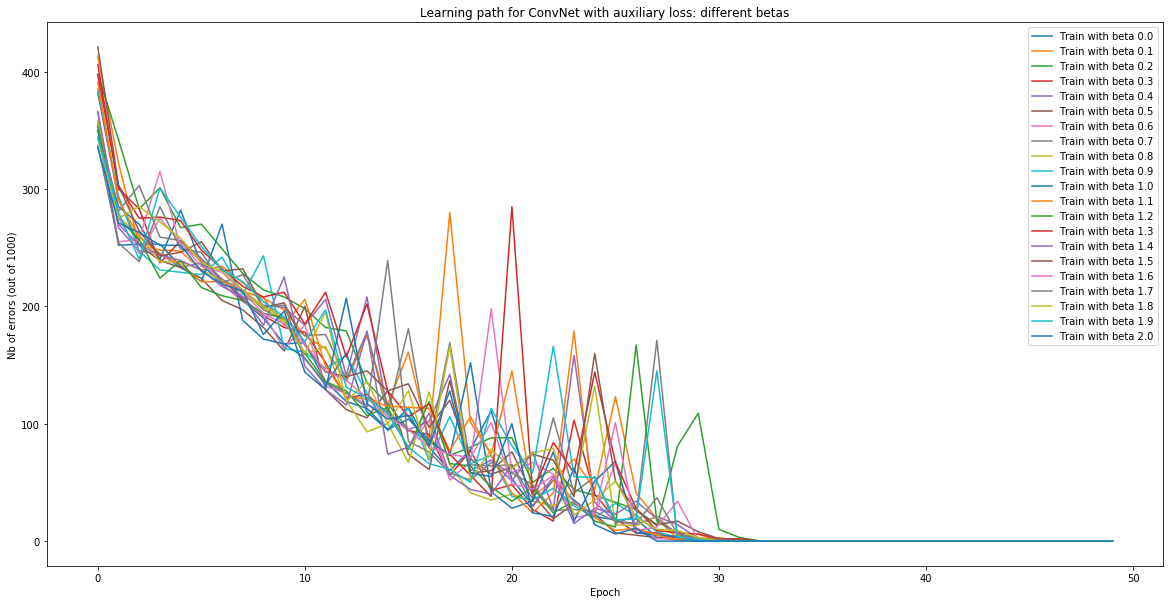

In [186]:
plt.figure(figsize=(20,10))
for i in range(0,21):
    plt.plot(train_paths[i], label = 'Train with beta ' + str(i/10))

plt.title('Learning path for ConvNet with auxiliary loss: different betas')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()

Given beta =  0.0 --> Final Test Error: 173/1000
Given beta =  0.1 --> Final Test Error: 191/1000
Given beta =  0.2 --> Final Test Error: 177/1000
Given beta =  0.3 --> Final Test Error: 199/1000
Given beta =  0.4 --> Final Test Error: 196/1000
Given beta =  0.5 --> Final Test Error: 177/1000
Given beta =  0.6 --> Final Test Error: 181/1000
Given beta =  0.7 --> Final Test Error: 177/1000
Given beta =  0.8 --> Final Test Error: 165/1000
Given beta =  0.9 --> Final Test Error: 170/1000
Given beta =  1.0 --> Final Test Error: 180/1000
Given beta =  1.1 --> Final Test Error: 196/1000
Given beta =  1.2 --> Final Test Error: 182/1000
Given beta =  1.3 --> Final Test Error: 170/1000
Given beta =  1.4 --> Final Test Error: 164/1000
Given beta =  1.5 --> Final Test Error: 179/1000
Given beta =  1.6 --> Final Test Error: 183/1000
Given beta =  1.7 --> Final Test Error: 174/1000
Given beta =  1.8 --> Final Test Error: 180/1000
Given beta =  1.9 --> Final Test Error: 182/1000
Given beta =  2.0 --

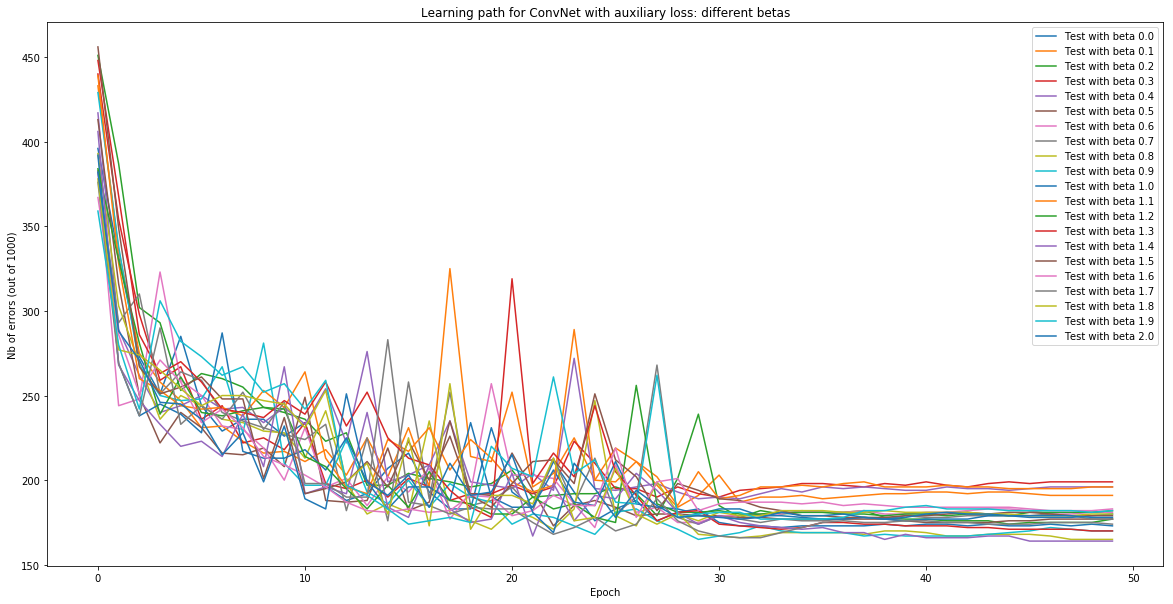

In [188]:
plt.figure(figsize=(20,10))
for i in range(0,21):
    plt.plot(test_paths[i], label = 'Test with beta '+str(i/10))
    print('Given beta = ', i/10, '--> Final Test Error: {}/1000'.format(compute_nb_errors(models[i], test_X, test_Y, 100)))

plt.title('Learning path for ConvNet with auxiliary loss: different betas')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()


In [189]:
test_errors = []
for i in range(0,21):
    test_errors.append(compute_nb_errors(models[i], test_X, test_Y, 100))

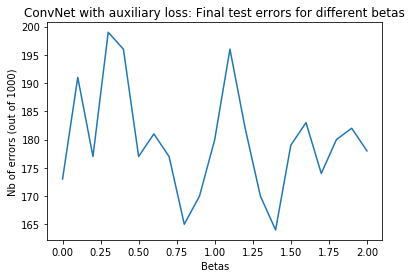

In [190]:
betas = np.arange(0,2.1,0.1)
plt.plot(betas,test_errors)
plt.title('ConvNet with auxiliary loss: Final test errors for different betas')
plt.xlabel('Betas')
plt.ylabel('Nb of errors (out of 1000)')
plt.show()